In [1]:
# Import packages 
import os
import sys

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.colors as colors

from scipy.io import FortranFile
from scipy.interpolate import LinearNDInterpolator as Li
from scipy.interpolate import NearestNDInterpolator as Ni
from scipy.spatial import Delaunay as Dl

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import importlib
import glob
import copy

/project/amp/juliob/MiniConda/envs/adf_v0.07/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ----------------------------------
# Functions to calculate area of
# triangle on a sphere
#-----------------------------------
def latlong_to_cartesian(latlong):
    phi   = np.deg2rad( 90 - latlong[0] )
    theta = np.deg2rad( latlong[1] )
    
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return np.array([x,y,z])
    
def spherical_area(a, b, c):
    t = np.abs( np.inner(a, np.cross(b, c) ) )
    t /= 1 + np.inner(a,b) + np.inner(b,c) + np.inner(a,c)
    return 2*np.arctan(t)
    
def flat_area(a, b, c):
    x = np.cross(a - b, c - b)
    return 0.5*np.linalg.norm(x)


In [3]:
#scripF='/glade/p/cesmdata/inputdata/share/scripgrids/C540_SCRIP_desc.230330.nc'
scripF='/home/juliob/geos_grid_files/PE1080x6480-CF.nc4'
dS=xr.open_dataset(scripF)

In [4]:
print(list(dS.variables))

['grid_dims', 'grid_imask', 'grid_center_lon', 'grid_center_lat', 'grid_corner_lon', 'grid_corner_lat', 'grid_area']


In [5]:
lon=dS['grid_center_lon'].values
lat=dS['grid_center_lat'].values
crlon=dS['grid_corner_lon'].values
crlat=dS['grid_corner_lat'].values
grid_area=dS['grid_area'].values


lonx0=crlon[:,0]
latx0=crlat[:,0]
lonx1=crlon[:,1]
latx1=crlat[:,1] 
lonx2=crlon[:,2]
latx2=crlat[:,2]
lonx3=crlon[:,3]
latx3=crlat[:,3] 

In [6]:
print(np.sum(grid_area) , 4.*np.pi )

12.566370696337907 12.566370614359172


## A good place to STOP for a while

In [7]:
refinement_c = np.sqrt( np.max(grid_area) / grid_area )
irefinement_c=np.round(refinement_c)

In [8]:
print(np.min(irefinement_c))
print(np.max(irefinement_c))


1.0
8.0


In [10]:
xlat=np.linspace(-90,90,num=181)
xlon=np.linspace(0,360,num=360)
X,Y=np.meshgrid(xlon,xlat)
print(X.shape)

ooo=np.c_[lon,lat]
dlo=Dl(ooo)

# Interpolote ocean mask to lat lon
grinx = Ni( dlo, grid_area )
grid_area_xy = grinx( X, Y )

(181, 360)


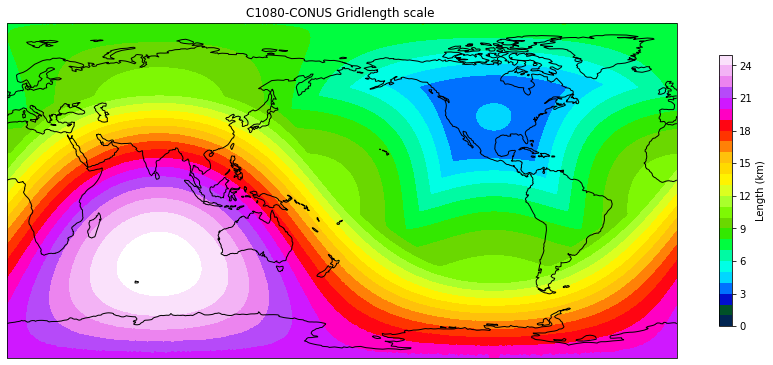

In [14]:
Rearth = 6378.1
grid_length = np.sqrt((Rearth**2)* grid_area_xy )
clev=np.linspace(0,25,num=26)
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.))
ax.coastlines(color="black")

cf = ax.contourf(xlon, xlat, grid_length ,  levels=clev  , transform=ccrs.PlateCarree() , cmap="gist_ncar")
ax.set_title( "C1080-CONUS Gridlength scale ")
plt.colorbar(cf,ax=ax,shrink=.5,label='Length (km)')

In [ ]:
dScopy = copy.deepcopy( dS )
Dar1 = xr.DataArray( data=grid_area , dims=['grid_size']  , 
                    attrs=dict( description='Grid_cell_area',units='Steradians',) ,) 

dScopy['grid_area']=Dar1

Dar2 = xr.DataArray( data=irefinement_c , dims=['grid_size']  , 
                    attrs=dict( description='Integer_Refinement_Factor',units='1',) ,) 
    
dScopy['grid_refinement_factor']=Dar2

newFilen = 'PE1080x6480-Refinement-CF.nc'
dScopy.to_netcdf( newFilen )